In [1]:
import numpy as np
import pandas as pd
import os, warnings, math
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf','svg')

warnings.filterwarnings("ignore")

## Building Metadata

In [2]:
building_df = pd.read_csv("../data/building_metadata.csv")
building_df.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


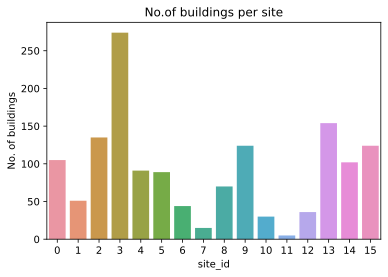

In [3]:
sns.countplot(data=building_df,x='site_id')
plt.title("No.of buildings per site")
plt.ylabel("No. of buildings")
plt.show()

We observe most sites to have about 50-150 buildings.

Site no. 3 has most no. of buildings.

Sites 11,7,10,12 have few no. of buildings.

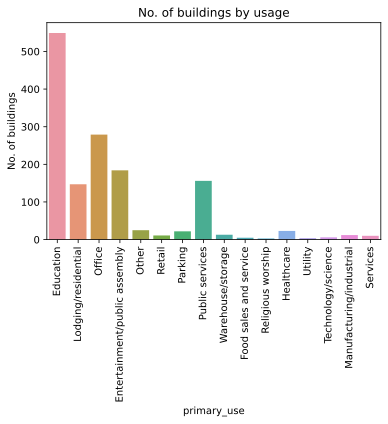

In [4]:
sns.countplot(data=building_df,x='primary_use')
plt.xticks(rotation=90)
plt.title("No. of buildings by usage")
plt.ylabel("No. of buildings")
plt.show()

Most buildings are used for Educational purposes and office purposes

So we might expect majority of buildings to have most electrical load from 9:00 to 18:00

We might also expect to have most buildings where vacation months have low consumption.

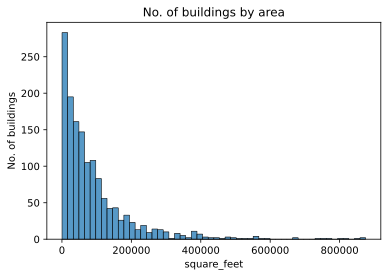

In [5]:
sns.histplot(building_df,x='square_feet')
plt.title("No. of buildings by area")
plt.ylabel("No. of buildings")
plt.show()

In [6]:
min_sq_ft = min(building_df['square_feet'])
max_sq_ft = max(building_df['square_feet'])
print("Min Square foot: {}\nMax Square foot: {}".format(min_sq_ft,max_sq_ft))

Min Square foot: 283
Max Square foot: 875000


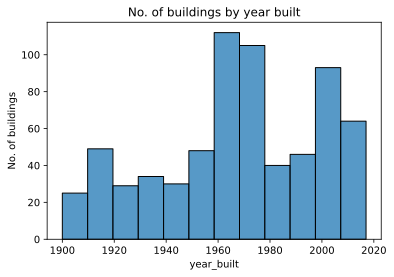

In [7]:
sns.histplot(building_df,x='year_built')
plt.title("No. of buildings by year built")
plt.ylabel("No. of buildings")
plt.show()

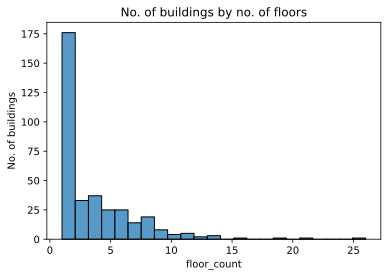

In [8]:
sns.histplot(building_df,x='floor_count')
plt.title("No. of buildings by no. of floors")
plt.ylabel("No. of buildings")
plt.show()

In [9]:
missing_floor_count = building_df["floor_count"].isnull().sum()
missing_floor_percent = missing_floor_count/len(building_df)*100

print("{} buildings ({}%) have floor_count missing".format(missing_floor_count, round(missing_floor_percent,4)))

1094 buildings (75.5003%) have floor_count missing


## Weather data

In [11]:
train_weather_df = pd.read_csv("../data/weather_train.csv")
train_weather_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [11]:
def time_plots_by_site(df,col,save=True,base_dir="../images/eda/",top_dir="",site=None):
    def plot(site):
        fig = px.line(df[df["site_id"]==site], x='timestamp', y=col)
            
        fig.update_layout(
            title="{} at site {}".format(col,site),
            autosize=False,
            width=1800,
            height=600)
        return fig
        
    if save:
        path = os.path.join(base_dir,top_dir)
        if not os.path.exists(path):
            os.makedirs(path)
        
        for _site in df['site_id'].unique():
            fig = plot(_site)
            fig.write_image("{}/{}_site{}.png".format(path,col,_site))
        
    if site is not None:
        fig = plot(site)
        fig.show()

Saving all plots locally:

In [12]:
if not os.path.exists("../images/eda/weather"):
    for col in train_weather_df.columns[1:]:
        time_plots_by_site(df=train_weather_df, col=col,top_dir="weather",save=True)

Air temp. of site 0: (Loaded from disk)

![Air temp. of site 0](../images/eda/weather/air_temperature_site0.png)

We observe seasonal effects, where temp. peaks at around June - July / september - october at most sites.

We also observe daily day-night temperature fluctuations

## Data Minification:

In [4]:
# Credit to kyakovlev; https://www.kaggle.com/kyakovlev/ashrae-data-minification
# Minifies dataset so that they use the least amount of memory they could, without data loss

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    # Bytes to MB
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                # np.iinfo() returns min and max limit of an int type
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
          
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

##############################################################
def timestamp_to_date(df):#train_df, test_df, train_weather_df, test_weather_df
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df
        
def new_time_features(df):#train_df, test_df
    df['DT_M'] = df['timestamp'].dt.month.astype(np.int8)
    df['DT_W'] = df['timestamp'].dt.weekofyear.astype(np.int8)
    df['DT_D'] = df['timestamp'].dt.dayofyear.astype(np.int16)
    
    df['DT_hour'] = df['timestamp'].dt.hour.astype(np.int8)
    df['DT_day_week'] = df['timestamp'].dt.dayofweek.astype(np.int8)
    df['DT_day_month'] = df['timestamp'].dt.day.astype(np.int8)
    df['DT_week_month'] = df['timestamp'].dt.day/7
    df['DT_week_month'] = df['DT_week_month'].apply(lambda x: math.ceil(x)).astype(np.int8)
    return df
    
def building_transform():
    ########################### Strings to category #########################################
    building_df['primary_use'] = building_df['primary_use'].astype('category')

    ########################### Building Transform ##########################################
    building_df['floor_count'] = building_df['floor_count'].fillna(0).astype(np.int8)
    building_df['year_built'] = building_df['year_built'].fillna(-999).astype(np.int16)

    le = LabelEncoder()
    building_df['primary_use'] = building_df['primary_use'].astype(str)
    building_df['primary_use'] = le.fit_transform(building_df['primary_use']).astype(np.int8)

########################### Base check #################################################
def conversion_and_check(df):#train_df, test_df, building_df, train_weather_df, test_weather_df
    do_not_convert = ['category','datetime64[ns]','object'] #cannot compress further
    original = df.copy()
    df = reduce_mem_usage(df)

    for col in list(df):
        if df[col].dtype.name not in do_not_convert:
            if (df[col]-original[col]).sum()!=0:# Data loss
                df[col] = original[col] #Revert to original
                print('Bad transformation', col)
    return df

In [14]:
if not os.path.exists("../data/train_reduced.pkl'):
    train_df = pd.read_csv('../data/train.csv')
    train_df = timestamp_to_date(train_df)
    train_df = new_time_features(train_df)
    train_df = conversion_and_check(train_df)


    train_df.to_pickle('../data/train_reduced.pkl')
    print("Sucessfully pickled")
    del train_df

Mem. usage decreased to 443.43 Mb (42.5% reduction)
Bad transformation meter_reading
Sucessfully pickled


In [5]:
if not os.path.exists("../data/test_reduced.pkl"):
    test_df = pd.read_csv('../data/test.csv')
    test_df = timestamp_to_date(test_df)
    test_df = new_time_features(test_df)
    test_df = conversion_and_check(test_df)


    test_df.to_pickle('../data/test_reduced.pkl')
    print("Sucessfully pickled")
    del test_df

Mem. usage decreased to 914.62 Mb (42.5% reduction)
Sucessfully pickled


In [9]:
if not os.path.exists("../data/building_df_reduced.pkl"):
    building_transform()
    building_df = conversion_and_check(building_df)

    building_df.to_pickle('../data/building_df_reduced.pkl')
    print("Sucessfully pickled")
    del building_df

Mem. usage decreased to  0.02 Mb (0.0% reduction)
Sucessfully pickled


In [12]:
if not os.path.exists("../data/train_weather_reduced.pkl"):
    train_weather_df = timestamp_to_date(train_weather_df)
    train_weather_df = conversion_and_check(train_weather_df)

    train_weather_df.to_pickle('../data/train_weather_reduced.pkl')
    print("Sucessfully pickled")
    del train_weather_df

Mem. usage decreased to  3.07 Mb (68.1% reduction)
Bad transformation air_temperature
Bad transformation dew_temperature
Bad transformation sea_level_pressure
Bad transformation wind_speed
Sucessfully pickled


In [13]:
if not os.path.exists("../data/test_weather_reduced.pkl"):

    test_weather_df = pd.read_csv("../data/weather_test.csv")
    test_weather_df = timestamp_to_date(test_weather_df)
    test_weather_df = conversion_and_check(test_weather_df)


    test_weather_df.to_pickle('../data/test_weather_reduced.pkl')
    print("Sucessfully pickled")
    del test_weather_df

Mem. usage decreased to  6.08 Mb (68.1% reduction)
Bad transformation air_temperature
Bad transformation dew_temperature
Bad transformation sea_level_pressure
Bad transformation wind_speed
Sucessfully pickled


## Train data:

In [3]:
with open("../data/train_reduced.pkl","rb") as pkl:
    train = pd.read_pickle(pkl)
    
train.head()

,building_id,meter,timestamp,meter_reading,DT_M,DT_W,DT_D,DT_hour,DT_day_week,DT_day_month,DT_week_month
0,0,0,2016-01-01,0.0,1,53,1,0,4,1,1
1,1,0,2016-01-01,0.0,1,53,1,0,4,1,1
2,2,0,2016-01-01,0.0,1,53,1,0,4,1,1
3,3,0,2016-01-01,0.0,1,53,1,0,4,1,1
4,4,0,2016-01-01,0.0,1,53,1,0,4,1,1


All features DT* are added to the original dataset as additional features.
- DT_M : Month of the year
- DT_W : Week of the year 
- DT_D : Day of the year
- DT_hour : Hour of the day
- DT_day_week : Day of the week
- DT_day_month : Day of the month
- DT_week_month : Week of the month

In [19]:
meters_per_building = {}
for building in train["building_id"].unique():
    meters_present = np.sort(train[train["building_id"]==building]["meter"].unique())
    all_meters = np.array([False,False,False,False])
    all_meters[meters_present] = True
    meters_per_building.update({building:all_meters})

In [20]:
meters_per_building_df = pd.DataFrame.from_dict(meters_per_building,orient='index')
meters_per_building_df

,0,1,2,3
0,True,False,False,False
1,True,False,False,False
2,True,False,False,False
3,True,False,False,False
4,True,False,False,False
...,...,...,...,...
567,True,False,False,False
621,True,False,False,False
591,True,False,False,False
783,False,False,True,False


In [64]:
meters_count = pd.DataFrame({"meter_type":meters_per_building_df.sum().index,
"count":meters_per_building_df.sum().values})
meters_count

,meter_type,count
0,0,1413
1,1,498
2,2,324
3,3,145


No. of buildings with a meter type:

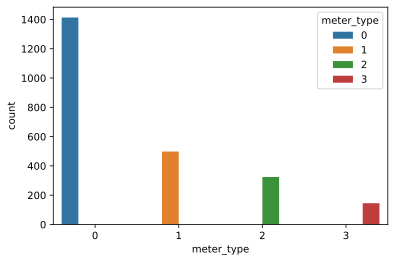

In [69]:
sns.barplot(x="meter_type",y="count",data=meters_count,hue="meter_type")
plt.show()

Buildings with no Meter 0:

In [72]:
meters_per_building_df[meters_per_building_df[0]==False]

,0,1,2,3
751,False,True,True,False
754,False,False,True,False
757,False,False,True,False
772,False,False,True,False
789,False,True,True,False
790,False,True,True,False
792,False,True,True,False
933,False,True,True,False
934,False,True,True,False
1072,False,True,True,False


1413 buildings have Meter 0, which is the dominant meter.
Whereas only 498 =, 324 and 145 buildings have Meter 1, Meter 2 and Meter 3 respectively.

In [18]:
def plot_building_meter_reading(building_id):
    fig = px.line(train[train["building_id"]==building_id],x='timestamp', y='meter_reading',color='meter')
    fig.update_layout(
            autosize=False,
            title="Meter Reading at building_{}".format(building_id),
            width=1200,
            height=450)
    return fig

In [20]:
plot_building_meter_reading(965)

![building_965](../images/eda/train/building_965.png)

Meter readings of the building 965 for the entire year. Some of these readings could also be outliers. We can decide on outliers by analysing data of buildings with same primary_use at the same site.